# Fully-Connected Neural Nets
The previous implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

Here is the implementation of a fully-connected networks using a more modular approach. We will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [20]:
# As usual, a bit of setup

import time
import numpy as np
import matplotlib.pyplot as plt
from utils.data_utils import get_CIFAR10_data

%matplotlib inline

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [21]:
# Load the (preprocessed) CIFAR10 data.
data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

y_test:  (1000,)
X_val:  (1000, 3, 32, 32)
y_train:  (49000,)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)


# Affine layer: foward


In [22]:
def affine_forward(x, w, b):
  """
  Computes the forward pass for an affine (fully-connected) layer.

  The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
  examples, where each example x[i] has shape (d_1, ..., d_k). We will
  reshape each input into a vector of dimension D = d_1 * ... * d_k, and
  then transform it to an output vector of dimension M.

  Inputs:
  - x: A numpy array containing input data, of shape (N, d_1, ..., d_k)
  - w: A numpy array of weights, of shape (D, M)
  - b: A numpy array of biases, of shape (M,)
  
  Returns a tuple of:
  - out: output, of shape (N, M)
  - cache: (x, w, b)
  """
  out = None
  out = x.reshape(x.shape[0], w.shape[0]).dot(w) + b
  cache = (x, w, b)
  return out, cache


In [23]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.76984946819e-10


# Affine layer: backward

## The below function is a naive implementation, just to check the correct values of backward layers.

In [24]:
def eval_numerical_gradient_array(f, x, df, h=1e-5):
  """
  Evaluate a numeric gradient for a function that accepts a numpy
  array and returns a numpy array.
  """
  grad = np.zeros_like(x)
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:
    ix = it.multi_index
    
    oldval = x[ix]
    x[ix] = oldval + h
    pos = f(x).copy()
    x[ix] = oldval - h
    neg = f(x).copy()
    x[ix] = oldval
    
    grad[ix] = np.sum((pos - neg) * df) / (2 * h)
    it.iternext()
  return grad


In [25]:
def eval_numerical_gradient(f, x, verbose=True, h=0.00001):
  """ 
  a naive implementation of numerical gradient of f at x 
  - f should be a function that takes a single argument
  - x is the point (numpy array) to evaluate the gradient at
  """ 

  fx = f(x) # evaluate function value at original point
  grad = np.zeros_like(x)
  # iterate over all indexes in x
  it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
  while not it.finished:

    # evaluate function at x+h
    ix = it.multi_index
    oldval = x[ix]
    x[ix] = oldval + h # increment by h
    fxph = f(x) # evalute f(x + h)
    x[ix] = oldval - h
    fxmh = f(x) # evaluate f(x - h)
    x[ix] = oldval # restore

    # compute the partial derivative with centered formula
    grad[ix] = (fxph - fxmh) / (2 * h) # the slope
    if verbose:
      print(ix, grad[ix])
    it.iternext() # step to next dimension

  return grad


In [26]:
def affine_backward(dout, cache):
  """
  Computes the backward pass for an affine layer.

  Inputs:
  - dout: Upstream derivative, of shape (N, M)
  - cache: Tuple of:
    - x: Input data, of shape (N, d_1, ... d_k)
    - w: Weights, of shape (D, M)

  Returns a tuple of:
  - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
  - dw: Gradient with respect to w, of shape (D, M)
  - db: Gradient with respect to b, of shape (M,)
  """
  x, w, b = cache
  dx, dw, db = None, None, None
  dw = x.reshape(x.shape[0], w.shape[0]).T.dot(dout)
  db = np.sum(dout, axis=0)
  dx = dout.dot(w.T).reshape(x.shape)
  return dx, dw, db


$$ y = wx + b $$

$$ \frac {de}{dw} = \frac {de}{dy} * \frac {dy}{dw} $$
$$ \frac {de}{dw} = dout * x^T $$

$$ \frac {de}{db} = \frac {de}{dy} * \frac {dy}{db} $$
$$ \frac {de}{db} = sum(\frac {de}{dy_i})$$ for all i

In [27]:
# Test the affine_backward function

x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  7.31089483731e-10
dw error:  7.03746713705e-11
db error:  2.50555722305e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

$$ y = max(0,x) $$

$$ \frac {de}{dx} = \frac {de}{dy} * \frac {dy}{dx} $$
$$ \frac {de}{dw} = dout $$ it is 0 for x<0 and 1 for x > 0


In [28]:
def relu_forward(x):
  """
  Computes the forward pass for a layer of rectified linear units (ReLUs).

  Input:
  - x: Inputs, of any shape

  Returns a tuple of:
  - out: Output, of the same shape as x
  - cache: x
  """
  out = None
  out = np.maximum(0, x)
  cache = x
  return out, cache

In [29]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 1e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.99999979802e-08


# ReLU layer: backward

In [30]:
def relu_backward(dout, cache):
  """
  Computes the backward pass for a layer of rectified linear units (ReLUs).

  Input:
  - dout: Upstream derivatives, of any shape
  - cache: Input x, of same shape as dout

  Returns:
  - dx: Gradient with respect to x
  """
  dx, x = None, cache
  dx = dout
  dx[cache < 0] = 0
  return dx

In [31]:
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 1e-12
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.27559827401e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, several convenience layers are defined

In [32]:
def affine_relu_forward(x, w, b):
  """
  Convenience layer that perorms an affine transform followed by a ReLU

  Inputs:
  - x: Input to the affine layer
  - w, b: Weights for the affine layer

  Returns a tuple of:
  - out: Output from the ReLU
  - cache: Object to give to the backward pass
  """
  a, fc_cache = affine_forward(x, w, b)
  out, relu_cache = relu_forward(a)
  cache = (fc_cache, relu_cache)
  return out, cache


def affine_relu_backward(dout, cache):
  """
  Backward pass for the affine-relu convenience layer
  """
  fc_cache, relu_cache = cache
  da = relu_backward(dout, relu_cache)
  dx, dw, db = affine_backward(da, fc_cache)
  return dx, dw, db


In [33]:

x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  1.43959866989e-10
dw error:  3.04072001973e-08
db error:  2.54799857951e-11


# Loss layers: Softmax and SVM
Re-implementation of soft-max-loss, done earlier
and new implementation of svm-loss

You can make sure that the implementations are correct by running the following:


$$p_j = \frac{e^{o_j}}{\sum_k e^{o_k}}$$

$$L = -\sum_j y_j \log p_j$$


$$\frac{\partial L}{\partial o_i}=-\sum_ky_k\frac{\partial \log p_k}{\partial o_i}=-\sum_ky_k\frac{1}{p_k}\frac{\partial p_k}{\partial o_i}\\=-y_i(1-p_i)-\sum_{k\neq i}y_k\frac{1}{p_k}({\color{red}{-p_kp_i}})\\=-y_i(1-p_i)+\sum_{k\neq i}y_k({\color{red}{p_i}})\\=-y_i+\color{blue}{y_ip_i+\sum_{k\neq i}y_k({p_i})}\\=\color{blue}{p_i\left(\sum_ky_k\right)}-y_i=p_i-y_i$$

$${\frac{\partial L}{\partial w_i}} = {\frac{\partial L}{\partial o_i}} * {\frac{\partial o_i}{\partial w_i}}$$

And $$o_i = w_i * x_i $$


In [42]:
def getsvmloss(x, y):
  """
  Computes the loss and gradient using for multiclass SVM classification.

  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C

  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  N = x.shape[0]
  correct_class_scores = x[np.arange(N), y]
  margins = np.maximum(0, x - correct_class_scores[:, np.newaxis] + 1.0)
  margins[np.arange(N), y] = 0
  loss = np.sum(margins) / N
  num_pos = np.sum(margins > 0, axis=1)
  dx = np.zeros_like(x)
  dx[margins > 0] = 1
  dx[np.arange(N), y] -= num_pos
  dx /= N
  return loss, dx


def getsoftmaxloss(x, y):
  """
  Computes the loss and gradient for softmax classification.

  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth class
    for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C

  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  probs = np.exp(x - np.max(x, axis=1, keepdims=True))
  probs /= np.sum(probs, axis=1, keepdims=True)
  N = x.shape[0]
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N
  dx = probs.copy()
  dx[np.arange(N), y] -= 1
  dx /= N
  return loss, dx


In [43]:
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: getsvmloss(x, y)[0], x, verbose = False)
loss, dx = getsvmloss(x, y)


print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: getsoftmaxloss(x, y)[0], x, verbose = False)
loss, dx = getsoftmaxloss(x, y)

print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))



Testing svm_loss:
loss:  8.99990026542
dx error:  3.0387355051e-09

Testing softmax_loss:
loss:  2.30257561251
dx error:  7.54057818074e-09


# Two-layer network

In [45]:
class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network with ReLU nonlinearity and
  softmax loss that uses a modular layer design. We assume an input dimension
  of D, a hidden dimension of H, and perform classification over C classes.
  
  The architecure should be affine - relu - affine - softmax.

  Note that this class does not implement gradient descent; instead, it
  will interact with a separate Solver object that is responsible for running
  optimization.

  The learnable parameters of the model are stored in the dictionary
  self.params that maps parameter names to numpy arrays.
  """
  
  def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=10,
               weight_scale=1e-3, reg=0.0):
    """
    Initialize a new network.

    Inputs:
    - input_dim: An integer giving the size of the input
    - hidden_dim: An integer giving the size of the hidden layer
    - num_classes: An integer giving the number of classes to classify
    - dropout: Scalar between 0 and 1 giving dropout strength.
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - reg: Scalar giving L2 regularization strength.
    """
    self.params = {}
    self.reg = reg
    self.params['b1'] = np.zeros(hidden_dim)
    self.params['W1'] = np.random.randn(input_dim, hidden_dim) * weight_scale
    self.params['b2'] = np.zeros(num_classes)
    self.params['W2'] = np.random.randn(hidden_dim, num_classes) * weight_scale


  def loss(self, X, y=None):
    """
    Compute loss and gradient for a minibatch of data.

    Inputs:
    - X: Array of input data of shape (N, d_1, ..., d_k)
    - y: Array of labels, of shape (N,). y[i] gives the label for X[i].

    Returns:
    If y is None, then run a test-time forward pass of the model and return:
    - scores: Array of shape (N, C) giving classification scores, where
      scores[i, c] is the classification score for X[i] and class c.

    If y is not None, then run a training-time forward and backward pass and
    return a tuple of:
    - loss: Scalar value giving the loss
    - grads: Dictionary with the same keys as self.params, mapping parameter
      names to gradients of the loss with respect to those parameters.
    """  
    scores = None
    
    W1, b1, W2, b2 = self.params['W1'], self.params['b1'], self.params['W2'], self.params['b2']
    # Forward into first layer
    hidden_layer, cache_hidden_layer = affine_relu_forward(X, W1, b1)
    # Forward into second layer
    scores, cache_scores = affine_forward(hidden_layer, W2, b2)
    
    # If y is None then we are in test mode so just return scores
    if y is None:
      return scores
    
    loss, grads = 0, {}
    data_loss, dscores = getsoftmaxloss(scores, y)
    reg_loss = 0.5 * self.reg * np.sum(W1**2)
    reg_loss += 0.5 * self.reg * np.sum(W2**2)
    loss = data_loss + reg_loss

    # Backprop into second layer
    dx1, dW2, db2 = affine_backward(dscores, cache_scores)
    dW2 += self.reg * W2

    # Backprop into first layer
    dx, dW1, db1 = affine_relu_backward(dx1, cache_hidden_layer)
    dW1 += self.reg * W1

    grads.update({'W1': dW1,
                  'b1': db1,
                  'W2': dW2,
                  'b2': db2})
    return loss, grads




In [46]:
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-2
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])

scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 7.98e-08
b1 relative error: 1.35e-08
b2 relative error: 9.09e-10


# Solver


In [47]:
# sgd function is used in Solver Class
def sgd(w, dw, config=None):
  """
  Performs vanilla stochastic gradient descent.

  config format:
  - learning_rate: Scalar learning rate.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-2)

  w -= config['learning_rate'] * dw
  return w, config


In [52]:

from utils import optim
class Solver(object):
  """
  A Solver encapsulates all the logic necessary for training classification
  models. The Solver performs stochastic gradient descent using different
  update rules defined in optim.py.

  The solver accepts both training and validataion data and labels so it can
  periodically check classification accuracy on both training and validation
  data to watch out for overfitting.

  To train a model, you will first construct a Solver instance, passing the
  model, dataset, and various optoins (learning rate, batch size, etc) to the
  constructor. You will then call the train() method to run the optimization
  procedure and train the model.
  
  After the train() method returns, model.params will contain the parameters
  that performed best on the validation set over the course of training.
  In addition, the instance variable solver.loss_history will contain a list
  of all losses encountered during training and the instance variables
  solver.train_acc_history and solver.val_acc_history will be lists containing
  the accuracies of the model on the training and validation set at each epoch.
  
  Example usage might look something like this:
  
  data = {
    'X_train': # training data
    'y_train': # training labels
    'X_val': # validation data
    'X_train': # validation labels
  }
  model = MyAwesomeModel(hidden_size=100, reg=10)
  solver = Solver(model, data,
                  update_rule='sgd',
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  lr_decay=0.95,
                  num_epochs=10, batch_size=100,
                  print_every=100)
  solver.train()


  A Solver works on a model object that must conform to the following API:

  - model.params must be a dictionary mapping string parameter names to numpy
    arrays containing parameter values.

  - model.loss(X, y) must be a function that computes training-time loss and
    gradients, and test-time classification scores, with the following inputs
    and outputs:

    Inputs:
    - X: Array giving a minibatch of input data of shape (N, d_1, ..., d_k)
    - y: Array of labels, of shape (N,) giving labels for X where y[i] is the
      label for X[i].

    Returns:
    If y is None, run a test-time forward pass and return:
    - scores: Array of shape (N, C) giving classification scores for X where
      scores[i, c] gives the score of class c for X[i].

    If y is not None, run a training time forward and backward pass and return
    a tuple of:
    - loss: Scalar giving the loss
    - grads: Dictionary with the same keys as self.params mapping parameter
      names to gradients of the loss with respect to those parameters.
  """

  def __init__(self, model, data, **kwargs):
    """
    Construct a new Solver instance.
    
    Required arguments:
    - model: A model object conforming to the API described above
    - data: A dictionary of training and validation data with the following:
      'X_train': Array of shape (N_train, d_1, ..., d_k) giving training images
      'X_val': Array of shape (N_val, d_1, ..., d_k) giving validation images
      'y_train': Array of shape (N_train,) giving labels for training images
      'y_val': Array of shape (N_val,) giving labels for validation images
      
    Optional arguments:
    - update_rule: A string giving the name of an update rule in optim.py.
      Default is 'sgd'.
    - optim_config: A dictionary containing hyperparameters that will be
      passed to the chosen update rule. Each update rule requires different
      hyperparameters (see optim.py) but all update rules require a
      'learning_rate' parameter so that should always be present.
    - lr_decay: A scalar for learning rate decay; after each epoch the learning
      rate is multiplied by this value.
    - batch_size: Size of minibatches used to compute loss and gradient during
      training.
    - num_epochs: The number of epochs to run for during training.
    - print_every: Integer; training losses will be printed every print_every
      iterations.
    - verbose: Boolean; if set to false then no output will be printed during
      training.
    """
    self.model = model
    self.X_train = data['X_train']
    self.y_train = data['y_train']
    self.X_val = data['X_val']
    self.y_val = data['y_val']
    
    # Unpack keyword arguments
    self.update_rule = kwargs.pop('update_rule', 'sgd')
    self.optim_config = kwargs.pop('optim_config', {})
    self.lr_decay = kwargs.pop('lr_decay', 1.0)
    self.batch_size = kwargs.pop('batch_size', 100)
    self.num_epochs = kwargs.pop('num_epochs', 10)

    self.print_every = kwargs.pop('print_every', 10)
    self.verbose = kwargs.pop('verbose', True)

    # Throw an error if there are extra keyword arguments
    if len(kwargs) > 0:
      extra = ', '.join('"%s"' % k for k in kwargs.keys())
      raise ValueError('Unrecognized arguments %s' % extra)

    # Make sure the update rule exists, then replace the string
    # name with the actual function
    if not hasattr(optim, self.update_rule):
      raise ValueError('Invalid update_rule "%s"' % self.update_rule)
    self.update_rule = getattr(optim, self.update_rule)

    self._reset()


  def _reset(self):
    """
    Set up some book-keeping variables for optimization. Don't call this
    manually.
    """
    # Set up some variables for book-keeping
    self.epoch = 0
    self.best_val_acc = 0
    self.best_params = {}
    self.loss_history = []
    self.train_acc_history = []
    self.val_acc_history = []

    # Make a deep copy of the optim_config for each parameter
    self.optim_configs = {}
    for p in self.model.params:
      d = {k: v for k, v in self.optim_config.items()}
      self.optim_configs[p] = d


  def _step(self):
    """
    Make a single gradient update. This is called by train() and should not
    be called manually.
    """
    # Make a minibatch of training data
    num_train = self.X_train.shape[0]
    batch_mask = np.random.choice(num_train, self.batch_size)
    X_batch = self.X_train[batch_mask]
    y_batch = self.y_train[batch_mask]

    # Compute loss and gradient
    loss, grads = self.model.loss(X_batch, y_batch)
    self.loss_history.append(loss)

    # Perform a parameter update
    for p, w in self.model.params.items():
      dw = grads[p]
      config = self.optim_configs[p]
      next_w, next_config = self.update_rule(w, dw, config)
      self.model.params[p] = next_w
      self.optim_configs[p] = next_config


  def check_accuracy(self, X, y, num_samples=None, batch_size=100):
    """
    Check accuracy of the model on the provided data.
    
    Inputs:
    - X: Array of data, of shape (N, d_1, ..., d_k)
    - y: Array of labels, of shape (N,)
    - num_samples: If not None, subsample the data and only test the model
      on num_samples datapoints.
    - batch_size: Split X and y into batches of this size to avoid using too
      much memory.
      
    Returns:
    - acc: Scalar giving the fraction of instances that were correctly
      classified by the model.
    """
    
    # Maybe subsample the data
    N = X.shape[0]
    if num_samples is not None and N > num_samples:
      mask = np.random.choice(N, num_samples)
      N = num_samples
      X = X[mask]
      y = y[mask]

    # Compute predictions in batches
    num_batches = N / batch_size
    if N % batch_size != 0:
      num_batches += 1
    y_pred = []
    for i in range(int(num_batches)):
      start = i * batch_size
      end = (i + 1) * batch_size
      scores = self.model.loss(X[start:end])
      y_pred.append(np.argmax(scores, axis=1))
    y_pred = np.hstack(y_pred)
    acc = np.mean(y_pred == y)

    return acc


  def train(self):
    """
    Run optimization to train the model.
    """
    num_train = self.X_train.shape[0]
    iterations_per_epoch = max(num_train / self.batch_size, 1)
    num_iterations = self.num_epochs * iterations_per_epoch
    num_iterations = int(num_iterations)
    for t in range(num_iterations):
      self._step()

      # Maybe print training loss
      if self.verbose and t % self.print_every == 0:
        print('(Iteration %d / %d) loss: %f' % (
               t + 1, num_iterations, self.loss_history[-1]))

      # At the end of every epoch, increment the epoch counter and decay the
      # learning rate.
      epoch_end = (t + 1) % iterations_per_epoch == 0
      if epoch_end:
        self.epoch += 1
        for k in self.optim_configs:
          self.optim_configs[k]['learning_rate'] *= self.lr_decay

      # Check train and val accuracy on the first iteration, the last
      # iteration, and at the end of each epoch.
      first_it = (t == 0)
      last_it = (t == num_iterations + 1)
      if first_it or last_it or epoch_end:
        train_acc = self.check_accuracy(self.X_train, self.y_train,
                                        num_samples=1000)
        val_acc = self.check_accuracy(self.X_val, self.y_val)
        self.train_acc_history.append(train_acc)
        self.val_acc_history.append(val_acc)

        if self.verbose:
          print('(Epoch %d / %d) train acc: %f; val_acc: %f' % (
                 self.epoch, self.num_epochs, train_acc, val_acc))

        # Keep track of the best model
        if val_acc > self.best_val_acc:
          self.best_val_acc = val_acc
          self.best_params = {}
          for k, v in self.model.params.items():
            self.best_params[k] = v.copy()

    # At the end of training swap the best params into the model
    self.model.params = self.best_params



In [53]:
model = TwoLayerNet()
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
solver = Solver(model, data,
              update_rule='sgd',
              optim_config={
                'learning_rate': 1e-3,
              },
              lr_decay=0.95,
              num_epochs=9, batch_size=200,
              print_every=100)
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 2205) loss: 2.301624
(Epoch 0 / 9) train acc: 0.138000; val_acc: 0.138000
(Iteration 101 / 2205) loss: 1.849290
(Iteration 201 / 2205) loss: 1.627083
(Epoch 1 / 9) train acc: 0.441000; val_acc: 0.422000
(Iteration 301 / 2205) loss: 1.588060
(Iteration 401 / 2205) loss: 1.535042
(Epoch 2 / 9) train acc: 0.481000; val_acc: 0.448000
(Iteration 501 / 2205) loss: 1.396555
(Iteration 601 / 2205) loss: 1.478717
(Iteration 701 / 2205) loss: 1.377191
(Epoch 3 / 9) train acc: 0.507000; val_acc: 0.472000
(Iteration 801 / 2205) loss: 1.329805
(Iteration 901 / 2205) loss: 1.341354
(Epoch 4 / 9) train acc: 0.539000; val_acc: 0.492000
(Iteration 1001 / 2205) loss: 1.392022
(Iteration 1101 / 2205) loss: 1.349737
(Iteration 1201 / 2205) loss: 1.318075
(Epoch 5 / 9) train acc: 0.521000; val_acc: 0.497000
(Iteration 1301 / 2205) loss: 1.280804
(Iteration 1401 / 2205) loss: 1.325458
(Epoch 6 / 9) train acc: 0.558000; val_acc: 0.482000
(Iteration 1501 / 2205) loss: 1.353180
(Iteration 1601 /

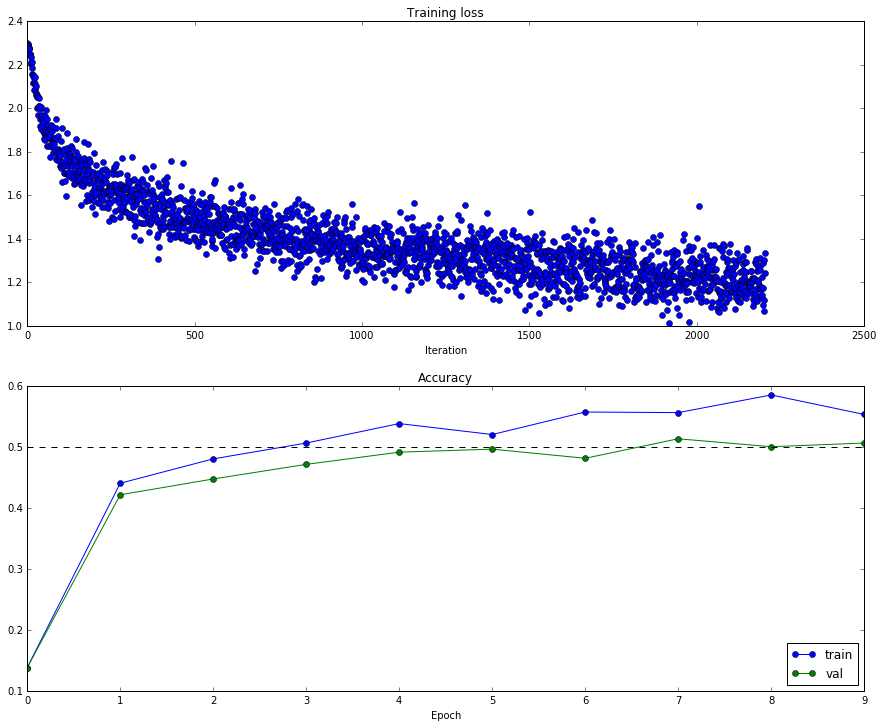

In [54]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next is the implementation of  a fully-connected network with an arbitrary number of hidden layers.

## Initial loss and gradient check

In [55]:
class FullyConnectedNet(object):
  """
  A fully-connected neural network with an arbitrary number of hidden layers,
  ReLU nonlinearities, and a softmax loss function. This will also implement
  dropout and batch normalization as options. For a network with L layers,
  the architecture will be
  
  {affine - [batch norm] - relu - [dropout]} x (L - 1) - affine - softmax
  
  where batch normalization and dropout are optional, and the {...} block is
  repeated L - 1 times.
  
  Similar to the TwoLayerNet above, learnable parameters are stored in the
  self.params dictionary and will be learned using the Solver class.
  """

  def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,dropout=0, use_batchnorm=False, reg=0.0,
               weight_scale=1e-2, dtype=np.float32, seed=None):
    """
    Initialize a new FullyConnectedNet.
    
    Inputs:
    - hidden_dims: A list of integers giving the size of each hidden layer.
    - input_dim: An integer giving the size of the input.
    - num_classes: An integer giving the number of classes to classify.
    - dropout: Scalar between 0 and 1 giving dropout strength. If dropout=0 then
      the network should not use dropout at all.
    - use_batchnorm: Whether or not the network should use batch normalization.
    - reg: Scalar giving L2 regularization strength.
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - dtype: A numpy datatype object; all computations will be performed using
      this datatype. float32 is faster but less accurate, so you should use
      float64 for numeric gradient checking.
    - seed: If not None, then pass this random seed to the dropout layers. This
      will make the dropout layers deteriminstic so we can gradient check the
      model.
    """
    self.use_batchnorm = use_batchnorm
    self.use_dropout = dropout > 0
    self.reg = reg
    self.num_layers = 1 + len(hidden_dims)
    self.dtype = dtype
    self.params = {}

    

    dims = [input_dim] + hidden_dims + [num_classes]
    print(dims)
    for i in range(self.num_layers):
      self.params['b%d' % (i+1)] = np.zeros(dims[i + 1])
      self.params['W%d' % (i+1)] = np.random.randn(dims[i], dims[i + 1]) * weight_scale

    # for k, v in self.params.iteritems():
    #   print '%s: ' % k, v.shape
    
    # When using dropout we need to pass a dropout_param dictionary to each
    # dropout layer so that the layer knows the dropout probability and the mode
    # (train / test). You can pass the same dropout_param to each dropout layer.
    self.dropout_param = {}
    if self.use_dropout:
      self.dropout_param = {'mode': 'train', 'p': dropout}
      if seed is not None:
        self.dropout_param['seed'] = seed
    
    # With batch normalization we need to keep track of running means and
    # variances, so we need to pass a special bn_param object to each batch
    # normalization layer. You should pass self.bn_params[0] to the forward pass
    # of the first batch normalization layer, self.bn_params[1] to the forward
    # pass of the second batch normalization layer, etc.
    self.bn_params = []
    if self.use_batchnorm:
      self.bn_params = [{'mode': 'train'} for i in range(self.num_layers - 1)]
    
    # Cast all parameters to the correct datatype
    for k, v in self.params.items():
      self.params[k] = v.astype(dtype)


  def loss(self, X, y=None):
    """
    Compute loss and gradient for the fully-connected net.

    Input / output: Same as TwoLayerNet above.
    """
    X = X.astype(self.dtype)
    mode = 'test' if y is None else 'train'

    # Set train/test mode for batchnorm params and dropout param since they
    # behave differently during training and testing.
    if self.dropout_param is not None:
      self.dropout_param['mode'] = mode   
    if self.use_batchnorm:
      for bn_param in self.bn_params:
        bn_param[mode] = mode

    scores = None
    
    layer = {}
    layer[0] = X
    cache_layer = {}

    for i in range(1, self.num_layers):
      layer[i], cache_layer[i] = affine_relu_forward(layer[i - 1],
                                                     self.params['W%d' % i],
                                                     self.params['b%d' % i])
    # Forward into last layer
    WLast = 'W%d' % self.num_layers
    bLast = 'b%d' % self.num_layers
    scores, cache_scores = affine_forward(layer[self.num_layers - 1],
                                          self.params[WLast],
                                          self.params[bLast])
    

    # If test mode return early
    if mode == 'test':
      return scores

    loss, grads = 0.0, {}
    
    loss, dscores = getsoftmaxloss(scores, y)

    # add regularization loss:
    for i in range(1, self.num_layers + 1):
      loss += 0.5 * self.reg * np.sum(self.params['W%d' % i]**2)

    # Backprop into last layer
    dx = {}
    dx[self.num_layers], grads[WLast], grads[bLast] = affine_backward(dscores, cache_scores)
    grads[WLast] += self.reg * self.params[WLast]

    # Backprop into remaining layers
    for i in reversed(range(1, self.num_layers)):
      # r = cache_layer[i + 1]
      dx[i], grads['W%d' % i], grads['b%d' % i] = affine_relu_backward(dx[i + 1], cache_layer[i])
      grads['W%d' % i] += self.reg * self.params['W%d' % i]
    

    return loss, grads


In [153]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.30270950161
W1 relative error: 1.33e-07
W2 relative error: 3.60e-07
W3 relative error: 5.87e-07
b1 relative error: 3.67e-08
b2 relative error: 6.34e-09
b3 relative error: 7.43e-11
Running check with reg =  3.14
Initial loss:  7.36720067365
W1 relative error: 6.25e-08
W2 relative error: 2.07e-08
W3 relative error: 1.14e-07
b1 relative error: 1.59e-07
b2 relative error: 1.17e-08
b3 relative error: 2.04e-10


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

[3072, 100, 100, 10]
(Iteration 1 / 40) loss: 2.297233
(Epoch 0 / 20) train acc: 0.320000; val_acc: 0.139000
(Epoch 1 / 20) train acc: 0.380000; val_acc: 0.121000
(Epoch 2 / 20) train acc: 0.360000; val_acc: 0.095000
(Epoch 3 / 20) train acc: 0.600000; val_acc: 0.148000
(Epoch 4 / 20) train acc: 0.560000; val_acc: 0.167000
(Epoch 5 / 20) train acc: 0.740000; val_acc: 0.158000
(Iteration 11 / 40) loss: 1.190570
(Epoch 6 / 20) train acc: 0.720000; val_acc: 0.149000
(Epoch 7 / 20) train acc: 0.800000; val_acc: 0.192000
(Epoch 8 / 20) train acc: 0.900000; val_acc: 0.167000
(Epoch 9 / 20) train acc: 0.940000; val_acc: 0.158000
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.165000
(Iteration 21 / 40) loss: 0.125251
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.169000
(Epoch 12 / 20) train acc: 0.980000; val_acc: 0.193000
(Epoch 13 / 20) train acc: 0.980000; val_acc: 0.168000
(Epoch 14 / 20) train acc: 0.940000; val_acc: 0.170000
(Epoch 15 / 20) train acc: 0.960000; val_acc: 0.192000
(Iter

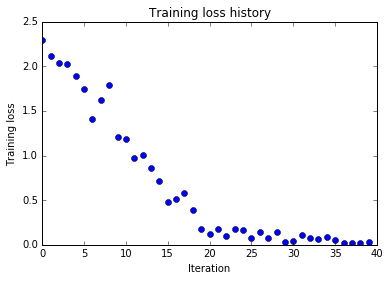

In [56]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-2 # was 1e-4
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

[3072, 100, 100, 100, 100, 10]
(Iteration 1 / 40) loss: 2.394134
(Epoch 0 / 20) train acc: 0.160000; val_acc: 0.105000
(Epoch 1 / 20) train acc: 0.280000; val_acc: 0.120000
(Epoch 2 / 20) train acc: 0.260000; val_acc: 0.112000
(Epoch 3 / 20) train acc: 0.620000; val_acc: 0.147000
(Epoch 4 / 20) train acc: 0.560000; val_acc: 0.140000
(Epoch 5 / 20) train acc: 0.660000; val_acc: 0.160000
(Iteration 11 / 40) loss: 1.300266
(Epoch 6 / 20) train acc: 0.720000; val_acc: 0.131000
(Epoch 7 / 20) train acc: 0.700000; val_acc: 0.118000
(Epoch 8 / 20) train acc: 0.860000; val_acc: 0.163000
(Epoch 9 / 20) train acc: 0.920000; val_acc: 0.166000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.191000
(Iteration 21 / 40) loss: 0.244030
(Epoch 11 / 20) train acc: 0.940000; val_acc: 0.154000
(Epoch 12 / 20) train acc: 0.960000; val_acc: 0.156000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.186000
(Epoch 14 / 20) train acc: 0.980000; val_acc: 0.161000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.19

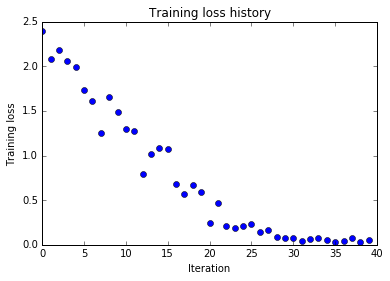

In [57]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 0.021  # was 1e-3
weight_scale = 0.036 # was 1e-5
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# SGD

$$ \theta = \theta - \alpha \nabla_\theta J(\theta; x^{(i)},y^{(i)}) $$



# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

$$ v = \gamma v+ \alpha \nabla_{\theta} J(\theta; x^{(i)},y^{(i)}) $$
$$ \theta = \theta - v $$


In [58]:
def sgd_momentum(w, dw, config=None):
  """
  Performs stochastic gradient descent with momentum.

  config format:
  - learning_rate: Scalar learning rate.
  - momentum: Scalar between 0 and 1 giving the momentum value.
    Setting momentum = 0 reduces to sgd.
  - velocity: A numpy array of the same shape as w and dw used to store a moving
    average of the gradients.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-2)
  config.setdefault('momentum', 0.9)
  v = config.get('velocity', np.zeros_like(w))
  
  next_w = None
  
  v = config['momentum'] * v - config['learning_rate'] * dw # integrate velocity
  next_w =  w + v
  
  config['velocity'] = v

  return next_w, config


In [59]:

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


running the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
[3072, 100, 100, 100, 100, 100, 10]
(Iteration 1 / 200) loss: 2.664546
(Epoch 0 / 5) train acc: 0.096000; val_acc: 0.113000
(Iteration 11 / 200) loss: 2.126844
(Iteration 21 / 200) loss: 2.074410
(Iteration 31 / 200) loss: 2.127168
(Epoch 1 / 5) train acc: 0.251000; val_acc: 0.259000
(Iteration 41 / 200) loss: 2.037746
(Iteration 51 / 200) loss: 1.903599
(Iteration 61 / 200) loss: 1.948135
(Iteration 71 / 200) loss: 1.780407
(Epoch 2 / 5) train acc: 0.324000; val_acc: 0.268000
(Iteration 81 / 200) loss: 1.925416
(Iteration 91 / 200) loss: 1.809198
(Iteration 101 / 200) loss: 1.875942
(Iteration 111 / 200) loss: 1.650454
(Epoch 3 / 5) train acc: 0.386000; val_acc: 0.318000
(Iteration 121 / 200) loss: 1.724721
(Iteration 131 / 200) loss: 1.796799
(Iteration 141 / 200) loss: 1.726487
(Iteration 151 / 200) loss: 1.740939
(Epoch 4 / 5) train acc: 0.425000; val_acc: 0.336000
(Iteration 161 / 200) loss: 1.616520
(Iteration 171 / 200) loss: 1.640331
(Iteration 181 / 200) loss

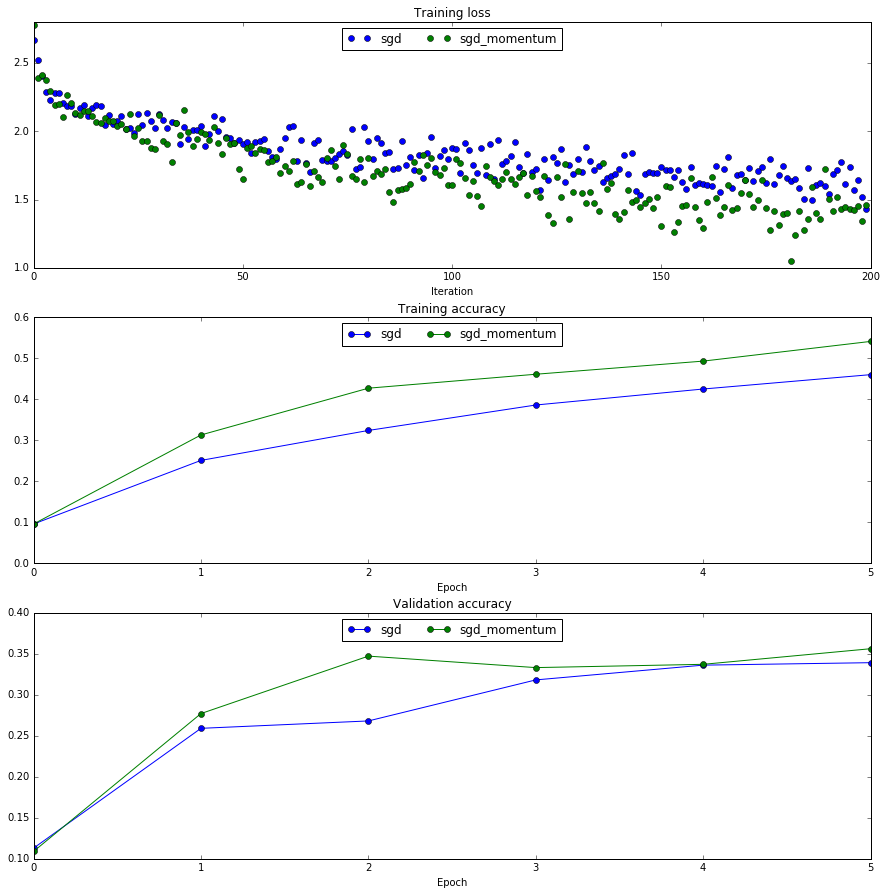

In [60]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-2,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

$$ E[g^2]_t = 0.9 E[g^2]_{t-1} + 0.1 g^2_t $$
$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \epsilon}} g_{t} $$

In [61]:
def rmsprop(x, dx, config=None):
  """
  Uses the RMSProp update rule, which uses a moving average of squared gradient
  values to set adaptive per-parameter learning rates.

  config format:
  - learning_rate: Scalar learning rate.
  - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
    gradient cache.
  - epsilon: Small scalar used for smoothing to avoid dividing by zero.
  - cache: Moving average of second moments of gradients.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-2)
  config.setdefault('decay_rate', 0.99)
  config.setdefault('epsilon', 1e-8)
  config.setdefault('cache', np.zeros_like(x))

  next_x = None
  
  cache, decay_rate, eps, learning_rate \
    = config['cache'], config['decay_rate'], \
      config['epsilon'], config['learning_rate']
  cache = decay_rate * cache + (1 - decay_rate) * dx**2
  next_x = -learning_rate * dx / (np.sqrt(cache) + eps) + x
  config['cache'] = cache
  
  return next_x, config


In [63]:
# Test RMSProp implementation; you should see errors less than 1e-7


N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.52468751104e-08
cache error:  2.64779558072e-09


http://ruder.io/optimizing-gradient-descent/index.html#rmsprop

In [64]:
def adam(x, dx, config=None):
  """
  Uses the Adam update rule, which incorporates moving averages of both the
  gradient and its square and a bias correction term.

  config format:
  - learning_rate: Scalar learning rate.
  - beta1: Decay rate for moving average of first moment of gradient.
  - beta2: Decay rate for moving average of second moment of gradient.
  - epsilon: Small scalar used for smoothing to avoid dividing by zero.
  - m: Moving average of gradient.
  - v: Moving average of squared gradient.
  - t: Iteration number.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-3)
  config.setdefault('beta1', 0.9)
  config.setdefault('beta2', 0.999)
  config.setdefault('epsilon', 1e-8)
  config.setdefault('m', np.zeros_like(x))
  config.setdefault('v', np.zeros_like(x))
  config.setdefault('t', 0)
  
  next_x = None

  learning_rate, beta1, beta2, eps, m, v, t \
    = config['learning_rate'], config['beta1'], config['beta2'], \
      config['epsilon'], config['m'], config['v'], config['t']

  t += 1
  m = beta1 * m + (1 - beta1) * dx
  v = beta2 * v + (1 - beta2) * (dx**2)

  # bias correction:
  mb = m / (1 - beta1**t)
  vb = v / (1 - beta2**t)

  next_x = -learning_rate * mb / (np.sqrt(vb) + eps) + x

  config['m'], config['v'], config['t'] = m, v, t

  
  return next_x, config



In [65]:
# Test Adam implementation; you should see errors around 1e-7 or less

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  1.13956917985e-07
v error:  4.20831403811e-09
m error:  4.21496319311e-09


Once debugged your RMSProp and Adam implementations, running the following to train a pair of deep networks using these new update rules:

running with  adam
[3072, 100, 100, 100, 100, 100, 10]
(Iteration 1 / 200) loss: 2.677111
(Epoch 0 / 5) train acc: 0.142000; val_acc: 0.145000
(Iteration 11 / 200) loss: 2.162941
(Iteration 21 / 200) loss: 1.929735
(Iteration 31 / 200) loss: 1.989622
(Epoch 1 / 5) train acc: 0.360000; val_acc: 0.335000
(Iteration 41 / 200) loss: 1.791679
(Iteration 51 / 200) loss: 1.626539
(Iteration 61 / 200) loss: 1.752157
(Iteration 71 / 200) loss: 1.487939
(Epoch 2 / 5) train acc: 0.436000; val_acc: 0.347000
(Iteration 81 / 200) loss: 1.701374
(Iteration 91 / 200) loss: 1.565987
(Iteration 101 / 200) loss: 1.466236
(Iteration 111 / 200) loss: 1.300897
(Epoch 3 / 5) train acc: 0.485000; val_acc: 0.356000
(Iteration 121 / 200) loss: 1.414986
(Iteration 131 / 200) loss: 1.309505
(Iteration 141 / 200) loss: 1.401578
(Iteration 151 / 200) loss: 1.423728
(Epoch 4 / 5) train acc: 0.559000; val_acc: 0.369000
(Iteration 161 / 200) loss: 1.201530
(Iteration 171 / 200) loss: 1.339439
(Iteration 181 / 200) los

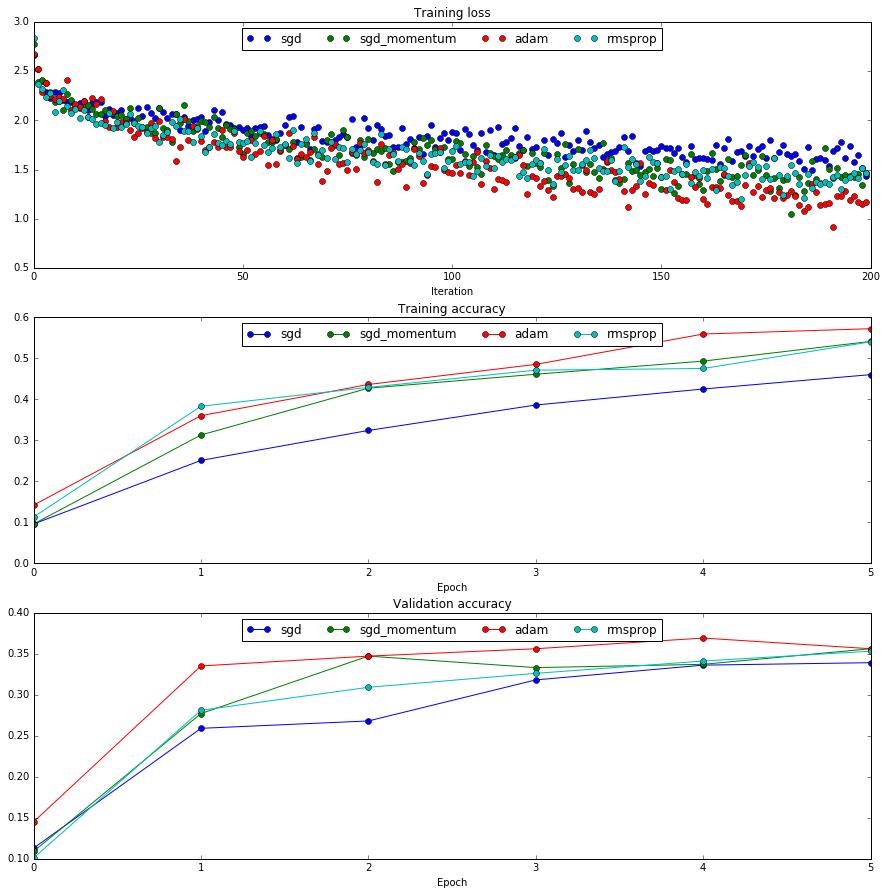

In [66]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()